In [2]:
import numpy as np
import matplotlib.pyplot as plt, os
os.chdir('icecube/bulkice_doumeki')



In [10]:
def energy_reweighting(energy_dist, time_dist, particle_type = 'Positron', gen_vol_side = 40, energy_bin_width = 0.5):

    gen_vol = gen_vol_side ** 3
    energy_bins = np.arange(np.min(energy_dist), np.max(energy_dist), energy_bin_width)
    N, edges = np.histogram(energy_dist, bins=energy_bins)
    centers = 0.5 * (edges[1:] + edges[:-1])
    widths = edges[1:] - edges[:-1] #assumes uniform energy binning
    dNdE = N / (gen_vol * widths) #m^-3 MeV^-1

    veff_lozano = 127.9 * centers 
    #weighting the dNdE by the effective volume
    dNdE_veff = dNdE * veff_lozano #m^-3 MeV^-1

    N_center = dNdE_veff * 1.5e4 * widths
    radius_eff = (3 * veff_lozano / (4 * np.pi))**(1/3)  # m

    # Ensure N_center is integer
    N_center = np.rint(N_center).astype(int)

    # Side length of cubic volume (±20m around origin)
    L = gen_vol_side
    halfL = L / 2.0

    # Storage for all particles (across bins)
    all_x, all_y, all_z = [], [], []

    for N, r_eff in zip(N_center, radius_eff):
        x_vals, y_vals, z_vals = [], [], []
        
        while len(x_vals) < N:
            # Propose uniform random points in cube
            x = np.random.uniform(-halfL, halfL, size=N)
            y = np.random.uniform(-halfL, halfL, size=N)
            z = np.random.uniform(-halfL, halfL, size=N)
            
            # Radial distance
            r = np.sqrt(x**2 + y**2 + z**2)
            
            # Accept only those within radius_eff
            mask = r <= r_eff
            
            x_vals.extend(x[mask].tolist())
            y_vals.extend(y[mask].tolist())
            z_vals.extend(z[mask].tolist())
        
        # Trim to exactly N and extend the global lists
        all_x.extend(x_vals[:N])
        all_y.extend(y_vals[:N])
        all_z.extend(z_vals[:N])

    # Convert to single 1D numpy arrays
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_z = np.array(all_z)

    all_E = []

    for N, mu, sigma in zip(N_center, centers, widths):
        # Sample N energies from Gaussian for this bin
        E_vals = np.random.normal(loc=mu, scale=sigma, size=N)
        all_E.extend(E_vals.tolist())

    # Convert to numpy array
    all_E = np.array(all_E)

    # Resample arrival times directly from empirical distribution
    all_t = np.random.choice(time_dist, size=len(all_E), replace=True)

    # Number of particles
    N_total = len(all_E)

    # Sample random directions isotropically
    phi = np.random.uniform(0, 2*np.pi, N_total)         # azimuth
    costheta = np.random.uniform(-1, 1, N_total)         # cos(theta)
    theta = np.arccos(costheta)

    # Convert to Cartesian components
    ax = np.sin(theta) * np.cos(phi)
    ay = np.sin(theta) * np.sin(phi)
    az = np.cos(theta)

    

                         

In [11]:
energy_reweighting(energy_dist, time_dist)

KeyboardInterrupt: 

In [3]:
energy_dist = np.loadtxt('mdom/InputFile/Positron/pos20002nkibd_energy.data')
time_dist = np.loadtxt('mdom/InputFile/Positron/pos20002nkibd_time.data')

In [4]:
len(energy_dist)

3538966

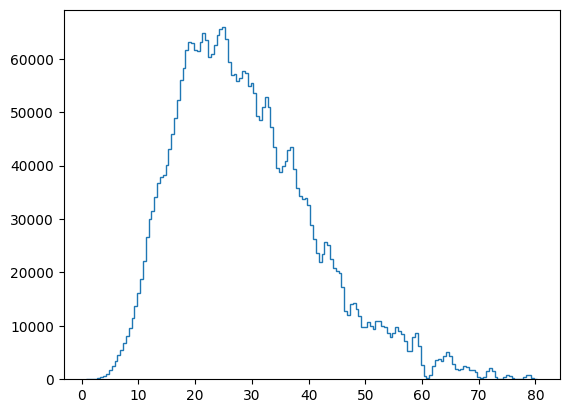

In [15]:
plt.hist(energy_dist, bins = np.arange(np.min(energy_dist), np.max(energy_dist), 0.5), histtype = 'step')
plt.show()

In [16]:
len(energy_dist)

3616449

In [ ]:
energy_bin_width = 0.5
energy_bins = np.arange(np.min(energy_dist), np.max(energy_dist), energy_bin_width)
counts_per_bin, edges = np.histogram(energy_dist, bins=energy_bins)
centers = 0.5 * (edges[1:] + edges[:-1])
widths = edges[1:] - edges[:-1] #assumes uniform energy binning

ndom = 15000
rng = np.random.default_rng(seed=42)
dom_ids = []

for count in counts_per_bin:
    if count == 0:
        continue
    
    m, c = divmod(count, ndom)

    # Step 1: give m particles to each DOM
    for dom in range(ndom):
        dom_ids.extend([dom] * m)

    # Step 2: randomly assign remainder c
    if c > 0:
        chosen_doms = rng.choice(ndom, size=c, replace=False)
        dom_ids.extend(chosen_doms)

dom_ids = np.array(dom_ids)



In [29]:
energy_dist = energy_dist[:len(dom_ids)]
energy_0 = energy_dist[dom_ids == 4104]

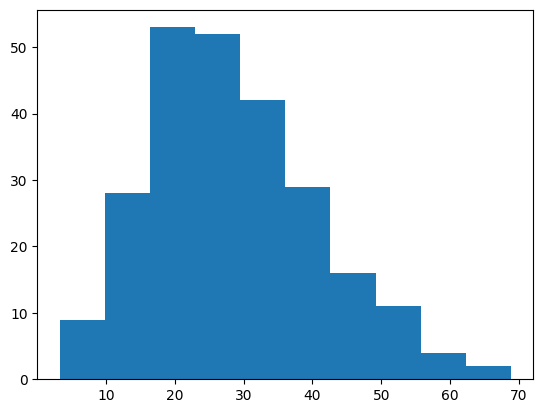

In [30]:
plt.hist(energy_0)
plt.show()

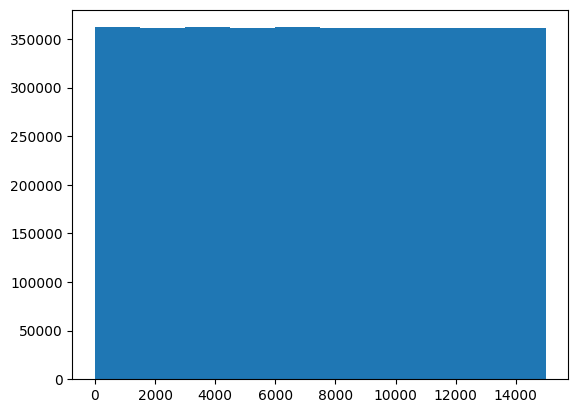

In [21]:
plt.hist(dom_ids)
plt.show()

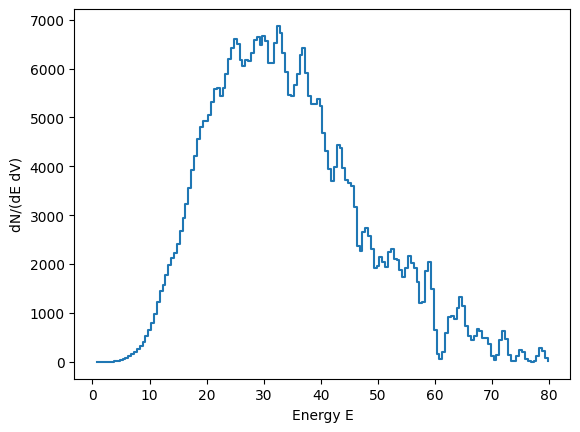

In [12]:
gen_vol = 40 * 40 * 40 #m^3
bins = np.arange(np.min(energy_dist), np.max(energy_dist), 0.5)
N, edges = np.histogram(energy_dist, bins=bins)
centers = 0.5 * (edges[1:] + edges[:-1])
widths = edges[1:] - edges[:-1] #assumes uniform energy binning
veff_lozano = 127.9 * centers
dNdE = (N / (gen_vol * widths))  #m^-3 MeV^-1
dnde_veff = dNdE * veff_lozano * widths #m^-3 MeV^-1

plt.step(edges[:-1], dnde_veff, where='post')
plt.xlabel('Energy E')
plt.ylabel('dN/(dE dV)')
plt.show()

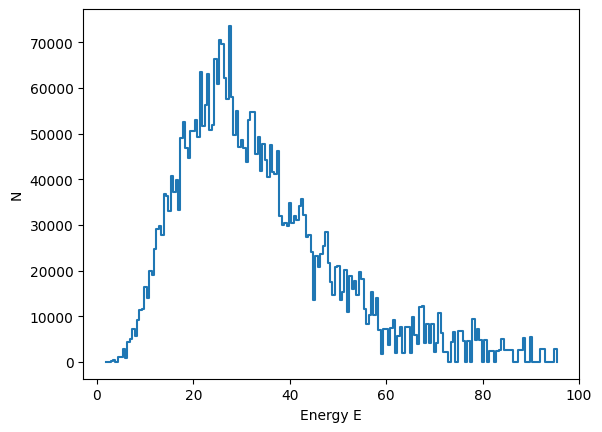

In [20]:
"""
effective volume per mDOM
as a function of energy approximated
by a straight line, taken from
Chris Lozano's thesis:

V(E) = (127.9 +/- 1.0 MeV) * E

N_mdom = 15000

Ignoring the uncertainty in the
following simulation
"""

veff_lozano = 127.9 * centers 
#weighting the dNdE by the effective volume
dNdE_veff = dNdE * veff_lozano #m^-3 MeV^-1
plt.step(edges[:-1], dNdE_veff * 1.5e4 * widths, where='post')
plt.xlabel('Energy E')
plt.ylabel('N')
plt.show()